<a href="https://colab.research.google.com/github/comandi1969/AIFFEL_Online_Quest/blob/main/DLthon/CIFAR10_ResNet18_%EA%B5%AC%ED%98%84_%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%A6%9D%EA%B0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dense, Add
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# 데이터 로딩 및 전처리
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# 클래스 레이블을 원핫인코딩으로 변환
from tensorflow.keras.utils import to_categorical
num_classes = 10  # CIFAR-10은 10개의 클래스로 구성됨
y_train_one_hot = to_categorical(y_train, num_classes)
y_test_one_hot = to_categorical(y_test, num_classes)


In [ ]:
# 이미지 데이터 증강
# ImageDataGenerator를 사용하여 이미지 데이터 증강을 적용하면 모델의 과적합을 줄이고 일반화 성능을 향상시킬 수 있습니다.
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,       # 이미지 회전 범위 (도)
    width_shift_range=0.1,  # 수평 방향으로 이동 범위 (전체 너비의 비율)
    height_shift_range=0.1, # 수직 방향으로 이동 범위 (전체 높이의 비율)
    shear_range=0.1,        # 전단 변환 범위
    zoom_range=0.1,         # 확대/축소 범위
    horizontal_flip=True,   # 수평 방향으로 뒤집기
    vertical_flip=False,   # 수직 방향으로 뒤집기
    fill_mode='nearest'     # 빈 공간을 어떻게 채울지 ('nearest', 'constant', 'reflect', 'wrap' 중 선택)
)
datagen.fit(x_train)

In [ ]:
# 로그 디렉터리 설정, 콜백함수 정의
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, LearningRateScheduler
import os

log_dir = "./logs"
if not os.path.exists(log_dir):
    os.mkdir(log_dir)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.95  # decrease the learning rate after 10 epochs

tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint = ModelCheckpoint('cifar10_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

In [ ]:
def identity_block(X, filters, kernel_size=3):
    F1, F2 = filters
    X_shortcut = X

    # First component
    X = Conv2D(F1, (kernel_size, kernel_size), padding='same')(X)
    X = BatchNormalization()(X)
    X = ReLU()(X)

    # Second component
    X = Conv2D(F2, (kernel_size, kernel_size), padding='same')(X)
    X = BatchNormalization()(X)

    # Add shortcut value
    X = Add()([X, X_shortcut])
    X = ReLU()(X)

    return X

def convolutional_block(X, filters, kernel_size=3, s=2):
    F1, F2 = filters
    X_shortcut = X

    # First component
    X = Conv2D(F1, (kernel_size, kernel_size), strides=(s, s), padding='same')(X)
    X = BatchNormalization()(X)
    X = ReLU()(X)

    # Second component
    X = Conv2D(F2, (kernel_size, kernel_size), padding='same')(X)
    X = BatchNormalization()(X)

    # Shortcut path
    X_shortcut = Conv2D(F2, (1, 1), strides=(s, s), padding='valid')(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)

    # Add shortcut value
    X = Add()([X, X_shortcut])
    X = ReLU()(X)

    return X

def ResNet18_CIFAR10(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Initial convolution
    X = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(inputs)
    X = BatchNormalization()(X)
    X = ReLU()(X)

    # ResNet blocks
    X = identity_block(X, [64, 64])
    X = identity_block(X, [64, 64])

    X = convolutional_block(X, [128, 128])
    X = identity_block(X, [128, 128])

    X = convolutional_block(X, [256, 256])
    X = identity_block(X, [256, 256])

    X = convolutional_block(X, [512, 512])
    X = identity_block(X, [512, 512])

    X = GlobalAveragePooling2D()(X)
    outputs = Dense(num_classes, activation='softmax')(X)

    model = Model(inputs=inputs, outputs=outputs)

    return model


In [ ]:
# Example of creating a ResNet18 model for CIFAR10 dataset
model = ResNet18_CIFAR10((32, 32, 3), 10)
model.summary()

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# 콜백함수
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
callbacks_list = [early_stopping, lr_scheduler]

# 모델 훈련
history = model.fit(datagen.flow(x_train, y_train_one_hot, batch_size=128),
                    epochs=200,
                    validation_data=(x_test, y_test_one_hot),
                    shuffle=True,
                    callbacks=callbacks_list)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 32, 32, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

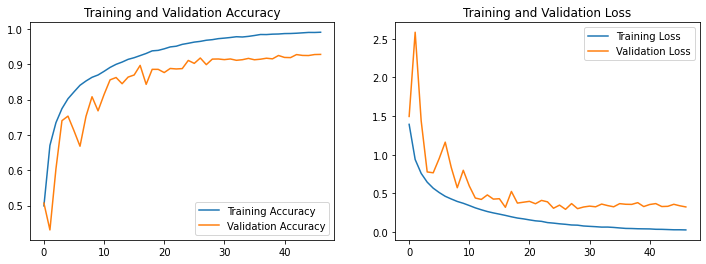

In [ ]:
# 학습 및 검증 정확도와 손실을 그래프로 표시
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

# 모델 학습 이후에 이 함수를 호출
plot_history(history)